In [1]:
import torch
import ast
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
train_binding_df = pd.read_csv("data/development_set/full_grouped_train_binding_sites_df.csv")
test_binding_df = pd.read_csv("data/development_set/full_grouped_test_binding_sites_df.csv")

In [3]:
display(train_binding_df)

,prot_id,binding_sites,ligand_type,sequence,sequence_length,metal_binding,small_binding,nuclear_binding,any_ligand_binding_sites
0,A0A0F7RDM3,"[29, 53, 129, 135, 137]",['metal'],MEIRKKLVVPSKYGTKCPYTMKPKYITVHNTYNDAPAENEVNYMIT...,234,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A0A0F7RHX8,"[67, 72, 76, 78, 123, 133, 135]",['small'],MHLKEKITTIIQGQRTGVLSTVRNDKPHSAFMMFFHEDFVLYVATD...,138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,A0A0H2W6Y8,"[85, 119, 125, 126, 129, 144, 197, 198, 207, 2...",['metal'],MMKILGLIGGMSWESTIPYYRMINQHVKAQLGGLHSAKIILYSVDF...,231,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A0A2B6C3P9,"[79, 111, 114, 117, 122, 125]",['metal'],MSINKWLFRFIGFLVMLVVITTLNSLNVFASVNDLAQPIASAKVIE...,129,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A0A384LKY8,"[5, 10, 12, 14, 43, 63, 72, 74, 76, 83, 85, 11...","['metal', 'small']",MSEHFVGKYEVELKFRVMDLTTLHEQLVAQKATAFTLNNHEKDIYL...,179,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ..."
...,...,...,...,...,...,...,...,...,...
1009,S0BAP9,"[56, 66, 69, 70, 72, 73, 77, 80, 81, 86, 89, 9...",['small'],MNPLSTVLLVLCATSAALASEFCSEADATIVIKQWNQIYNAGIGAK...,168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1010,S3TFW2,"[75, 79, 122, 192, 193, 204, 277, 278, 279, 28...",['small'],MTRPDSKSMNYQLLKTFSRQPIQFGRFLARLLAGLVNTLKITRTSK...,327,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1011,V6F235,"[230, 232, 255]",['small'],MRKSGCAVCSRSIGWVGLAVSTVLMVMKAFVGLIGGSQAMLADAMY...,318,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1012,V9P0A9,"[13, 33, 34, 37, 38, 42, 49, 51, 70, 72, 74, 7...",['small'],MADFKFEPMRSLIYVDCVSEDYRPKLQRWIYKVHIPDSISQFEPYV...,283,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [4]:
list_columns = ['any_ligand_binding_sites', 'metal_binding', 'small_binding', 'nuclear_binding']

for col in list_columns:
    test_binding_df[col] = test_binding_df[col].apply(ast.literal_eval)
    train_binding_df[col] = train_binding_df[col].apply(ast.literal_eval)

### Show distribution binding sites of amino acids

In [16]:
def analyze_amino_acid_binding(df, sequence_col, binding_cols):
    # Dictionary to store results
    aa_stats = {aa: {'binding': 0, 'non_binding': 0} for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    
    # Process each protein
    for idx, row in df.iterrows():
        sequence = row[sequence_col]
        
        # Combine all binding sites
        combined_binding = np.zeros(len(sequence))
        for col in binding_cols:
            binding_array = row[col]
            # print(f"Binding array: {binding_array}")
            # Ensure binding_array is the right length
            if len(binding_array) >= len(sequence):
                combined_binding = np.logical_or(combined_binding, binding_array[:len(sequence)])
        
        # print(f"Combined binding sequence: {combined_binding}")

        # Count binding and non-binding for each amino acid
        for i, aa in enumerate(sequence):
            if aa in aa_stats:
                if i < len(combined_binding) and combined_binding[i]:
                    aa_stats[aa]['binding'] += 1
                else:
                    aa_stats[aa]['non_binding'] += 1
    
    # print(f"Current amino acids counter dictonary: {aa_stats}")
    
    # Convert to DataFrame for easy plotting
    result = []
    for aa, counts in aa_stats.items():
        total = counts['binding'] + counts['non_binding']
        if total > 0:  # Avoid division by zero
            binding_percentage = counts['binding'] / total * 100
            result.append({
                'Amino Acid': aa,
                'Binding %': binding_percentage,
                'Non-binding %': 100 - binding_percentage,
                'Total Count': total
            })
    
    return pd.DataFrame(result)



### Test outputs before displaying distribution

In [17]:
binding_cols = ['any_ligand_binding_sites']
stats_df = analyze_amino_acid_binding(train_binding_df, 'sequence', binding_cols)

In [32]:
# Run the analysis
binding_cols = ['any_ligand_binding_sites']
train_stats_df = analyze_amino_acid_binding(train_binding_df, 'sequence', binding_cols)
test_stats_df = analyze_amino_acid_binding(test_binding_df, 'sequence', binding_cols)

# Sort by binding percentage for better visualization
train_stats_df = train_stats_df.sort_values('Binding %', ascending=False)
test_stats_df = test_stats_df.sort_values('Binding %', ascending=False)

def show_amino_acid_stats(stats_df):
    # Create a stacked bar chart
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    # Create the plot
    # ax = sns.barplot(x='Amino Acid', y='Total Count', data=stats_df, alpha=0.3, color='lightgrey')

    # # Add binding percentage bars
    # binding_bars = sns.barplot(x='Amino Acid', y = stats_df['Total Count'] * stats_df['Non-binding %'] / 100, 
    #                         data=stats_df, color='darkblue', label='Non-Binding')

    # # Add annotations
    # for i, row in enumerate(stats_df.itertuples()):
    #     plt.text(i, 5, f"{row._3:.1f}%", ha='center', color='white', fontweight='bold')

    # # Add a legend and labels
    # plt.legend(loc='upper right')
    # plt.xlabel('Amino Acid', fontsize=12)
    # plt.ylabel('Count', fontsize=12)
    # plt.title('Distribution of Binding vs Non-binding Sites by Amino Acid', fontsize=14)

    # # Add a second y-axis for percentages
    # ax2 = ax.twinx()
    # ax2.set_ylabel('Non-Binding Percentage (%)', fontsize=12)
    # ax2.set_ylim(0, 100)

    # plt.tight_layout()
    # plt.show()

    # For more detailed analysis, you can also create a heatmap showing binding preferences
    # Reshape the data for a heatmap
    heatmap_data = stats_df.set_index('Amino Acid')[['Binding %']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data.T, annot=True, cmap='Oranges', fmt='.1f', cbar_kws={'label': 'Binding %'})
    plt.title('Binding Site Percentage by Amino Acid')
    plt.tight_layout()
    plt.show()


<Figure size 1200x800 with 0 Axes>

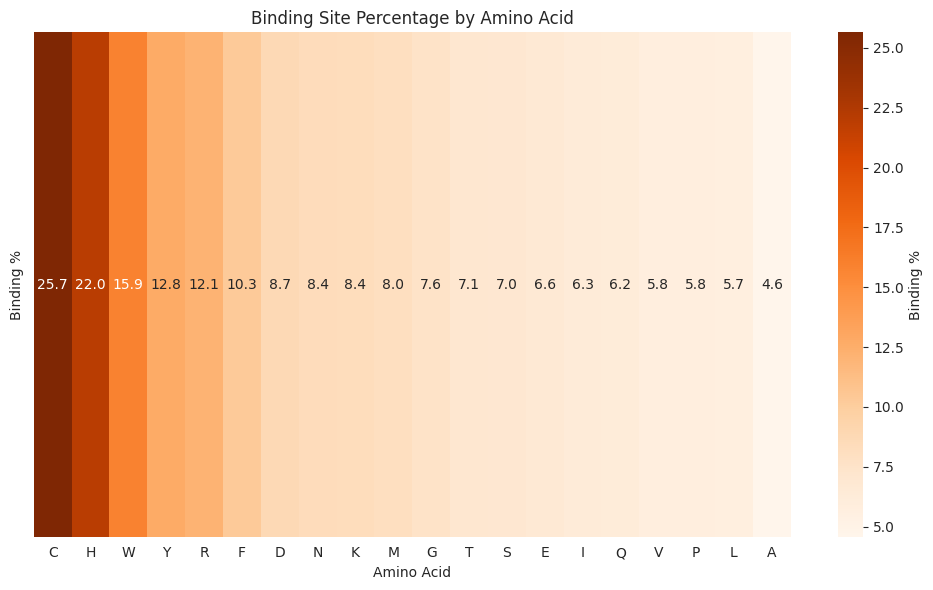

In [33]:
show_amino_acid_stats(train_stats_df)

<Figure size 1200x800 with 0 Axes>

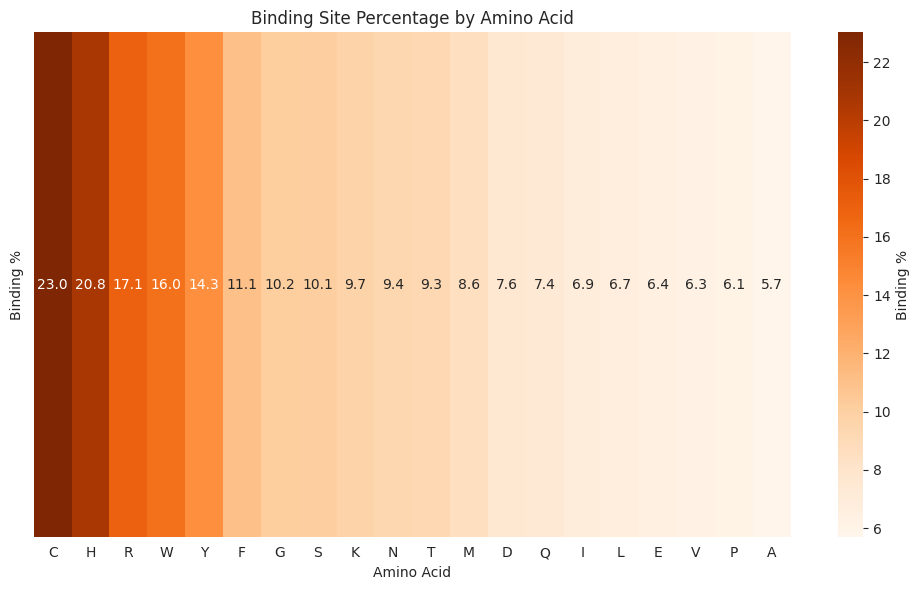

In [34]:
show_amino_acid_stats(test_stats_df)